In [1]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.integrate import quad

from hazma.vector_mediator import VectorMediator
from hazma.parameters import neutral_pion_mass as mpi0

## Vector mediator

In [3]:
vm = VectorMediator(mx=1., mv=1000., gvxx=1., gvuu=1., gvdd=0.2, gvss=0., gvee=0., gvmumu=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = mpi0/2., 250., 50
vm_mxs = np.linspace(mx_min, mx_max, n_mxs)

In [5]:
vm_lims_cmb = vm.cmb_limits(vm_mxs)

In [8]:
np.savetxt("data/vm_lims_cmb.csv",
           np.array([vm_mxs, vm_lims_cmb]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

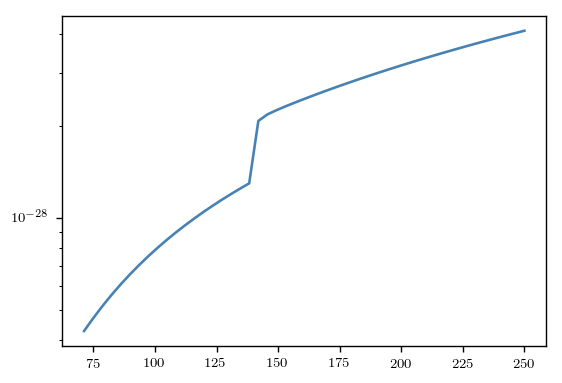

In [6]:
plt.plot(vm_mxs, cmb_limits)
plt.yscale("log")

## Scratch

In [12]:
(feff_ep_data[0] / 1e6)[0]

0.005020529913880202

In [5]:
feff_ep_data = np.loadtxt("cmb_data/f_eff_e+e-.csv", delimiter=",").T
feff_ep = UnivariateSpline(feff_ep_data[0] / 1e6, feff_ep_data[1])

feff_g_data = np.loadtxt("cmb_data/feff_photons.csv", delimiter=",").T
feff_g = UnivariateSpline(feff_g_data[0] / 1e6, feff_g_data[1])

(0.1, 10000000.0)

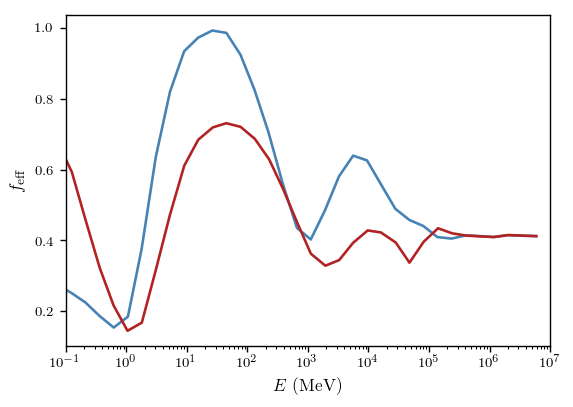

In [11]:
plt.plot(feff_ep_data[0] / 1e6, feff_ep_data[1])
plt.plot(feff_g_data[0] / 1e6, feff_g_data[1])
plt.xscale("log")
plt.xlabel(r"$E$ (MeV)")
plt.ylabel(r"$f_{\mathrm{eff}}$")
plt.xlim([0.1, 1e7])

In [71]:
def feff_vm(mx, mv=1000., gvxx=1., gvuu=1., gvdd=0.2, gvss=0., gvee=0., gvmumu=0., xkd=1.0e-4):
    vm = VectorMediator(mx, mv, gvxx, gvuu, gvdd, gvss, gvee, gvmumu)

    T_CMB = 0.235 # eV
    vx_cmb = 2.0e-4 * T_CMB/vm.mx * np.sqrt(1.0e-4 / xkd)  # see arXiv:1309.4091 eq. 28
    e_cm = 2.*vm.mx * (1. + 0.5 * vx_cmb**2)

    # Continuum spectrum functions. Note the factor of 2.
    dnde_ep = lambda e_ep: 2.*vm.positron_spectra(np.array([e_ep]), e_cm)["total"]
    dnde_g = lambda e_g: vm.spectra(np.array([e_g]), e_cm)["total"]
    # Line energies and branching fractions
    g_line_energy, g_line_bf = vm.gamma_ray_lines(e_cm)
    ep_line_energy, ep_line_bf = vm.positron_lines(e_cm)["e e"]
    
    # Continuum contribution to f_eff
    g_integrand = lambda e_g: e_g * dnde_g(e_g) * feff_g(e_g)
    ep_integrand = lambda e_ep: e_ep * dnde_ep(e_ep) * feff_ep(e_ep)
    
    # Debugging
#     e_s = np.logspace(-1, np.log10(mx), 100)
#     plt.plot(e_s, [g_integrand(e_g) for e_g in e_s])
#     plt.plot(e_s, [ep_integrand(e_ep) for e_ep in e_s])
#     plt.xscale("log")
#     plt.yscale("log")
    
    feff_g_dm = quad(g_integrand, 0, mx, epsabs=0, epsrel=1e-3)[0] / (2. * mx)
    feff_ep_dm = quad(ep_integrand, 0, mx, epsabs=0, epsrel=1e-3)[0] / (2. * mx)
    # Line contribution to f_eff
    feff_g_line_dm = g_line_bf * feff_g(g_line_energy) / (2. * mx)
    feff_ep_line_dm = 2. * ep_line_bf * feff_g(ep_line_energy) / (2. * mx)
    
    return feff_g_dm + feff_ep_dm + feff_g_line_dm

In [72]:
# Masses to scan over
mx_min, mx_max, n_mxs = 140., 250., 50
vm_mxs = np.linspace(mx_min, mx_max, n_mxs)

# Compute feff as a function of mass
feff_vms = np.array([feff_vm(mx) for mx in vm_mxs])

In [73]:
np.savetxt("data/f_eff_vm.csv", [vm_mxs, feff_vms.flatten()], delimiter=",", header="f_eff(m_x) for the vector simplified model.\nColumns are: mx (MeV), f_eff")

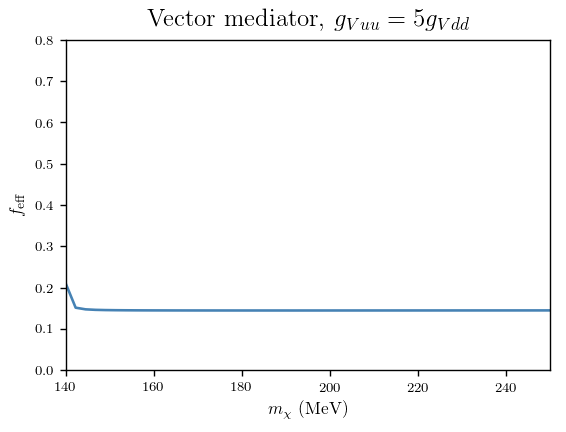

In [74]:
plt.plot(vm_mxs, feff_vms)

plt.xlim(vm_mxs[[0, -1]])
plt.ylim(0, 0.8)
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$f_{\mathrm{eff}}$")
plt.title(r"Vector mediator, $g_{Vuu} = %i g_{Vdd}$" % 5)

In [75]:
import os
os.system('say "Done computing f effective"')

0